<a href="https://colab.research.google.com/github/adildauletkhan/archi/blob/master/bab_fluid_logs_10wells_lithology_clay_smooth_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lasio matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
import zipfile
from scipy.ndimage import gaussian_filter1d


In [ ]:
well_coordinates = [
    {"name": "BB02431", "lon": 53.368286, "lat": 23.876383},
    {"name": "BB02531", "lon": 53.281390, "lat": 23.813915},
    {"name": "BB04441", "lon": 53.368785, "lat": 23.962976},
    {"name": "BB06641", "lon": 53.406376, "lat": 23.919027},
    {"name": "BB08381", "lon": 53.428662, "lat": 23.951690},
    {"name": "BB03230", "lon": 53.291111, "lat": 23.879456},
    {"name": "BB04567", "lon": 53.349876, "lat": 23.932145},
    {"name": "BB06543", "lon": 53.384932, "lat": 23.887456},
    {"name": "BB07654", "lon": 53.301234, "lat": 23.901239},
    {"name": "BB09123", "lon": 53.372345, "lat": 23.942876}
]


In [ ]:
folder = "BAB_litho_clay_smooth_logs"
os.makedirs(folder, exist_ok=True)

for i, well in enumerate(well_coordinates):
    depth = np.linspace(1000, 2000, 500)

    # задаем случайную глубину начала и конца газа
    gas_start = np.random.randint(1200, 1600)
    gas_end = gas_start + np.random.randint(100, 300)
    gas_zone = (depth >= gas_start) & (depth <= gas_end)

    gas_profile = np.zeros_like(depth)
    gas_profile[gas_zone] = np.random.uniform(0.05, 0.15, gas_zone.sum())
    gas_frac = gaussian_filter1d(gas_profile, sigma=10)

    max_water = 0.2 - gas_frac
    water_frac = np.clip(np.random.uniform(0.05, 0.15, len(depth)), 0, max_water)

    fluid_total = gas_frac + water_frac
    rock_total = 1 - fluid_total

    dolomite_ratio = np.random.uniform(0.3, 0.5, len(depth))
    calcite_ratio = np.random.uniform(0.2, 0.4, len(depth))
    clay_ratio = 1 - dolomite_ratio - calcite_ratio
    clay_ratio = np.clip(clay_ratio, 0.05, 0.4)

    mineral_total = dolomite_ratio + calcite_ratio + clay_ratio
    dolomite = dolomite_ratio / mineral_total * rock_total
    calcite = calcite_ratio / mineral_total * rock_total
    clay = clay_ratio / mineral_total * rock_total

    dt = 250 - 10 * dolomite + 2 * calcite + 8 * clay + 30 * gas_frac
    dt += np.random.normal(0, 2, len(depth))

    las = lasio.LASFile()
    las.append_curve("DEPT", depth, unit="m", descr="Depth")
    las.append_curve("DT", dt, unit="us/ft", descr="Delta-T")
    las.append_curve("DOLOMITE", dolomite * 100, unit="%", descr="Dolomite content")
    las.append_curve("CALCITE", calcite * 100, unit="%", descr="Calcite content")
    las.append_curve("CLAY", clay * 100, unit="%", descr="Clay content")
    las.append_curve("GAS", gas_frac * 100, unit="%", descr="Gas saturation")
    las.append_curve("WATER", water_frac * 100, unit="%", descr="Water saturation")
    las.well.WELL.value = well["name"]
    las.well.LOC.value = f"Lat={well['lat']}, Lon={well['lon']}"
    las.write(f"{folder}/{well['name']}.las")

print("✅ LAS files generated with CLAY and smoothed gas transitions.")


✅ LAS files generated with CLAY and smoothed gas transitions.


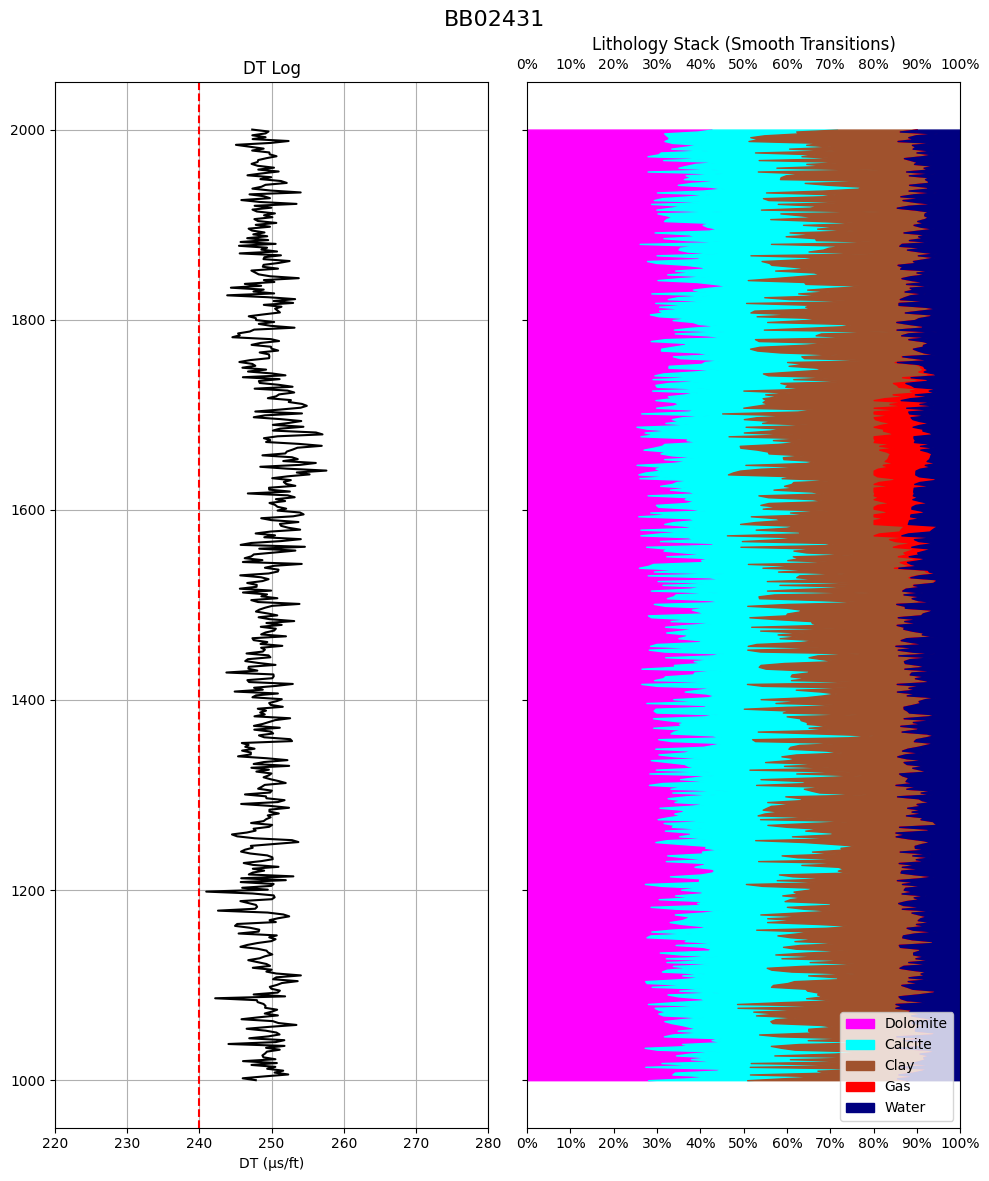

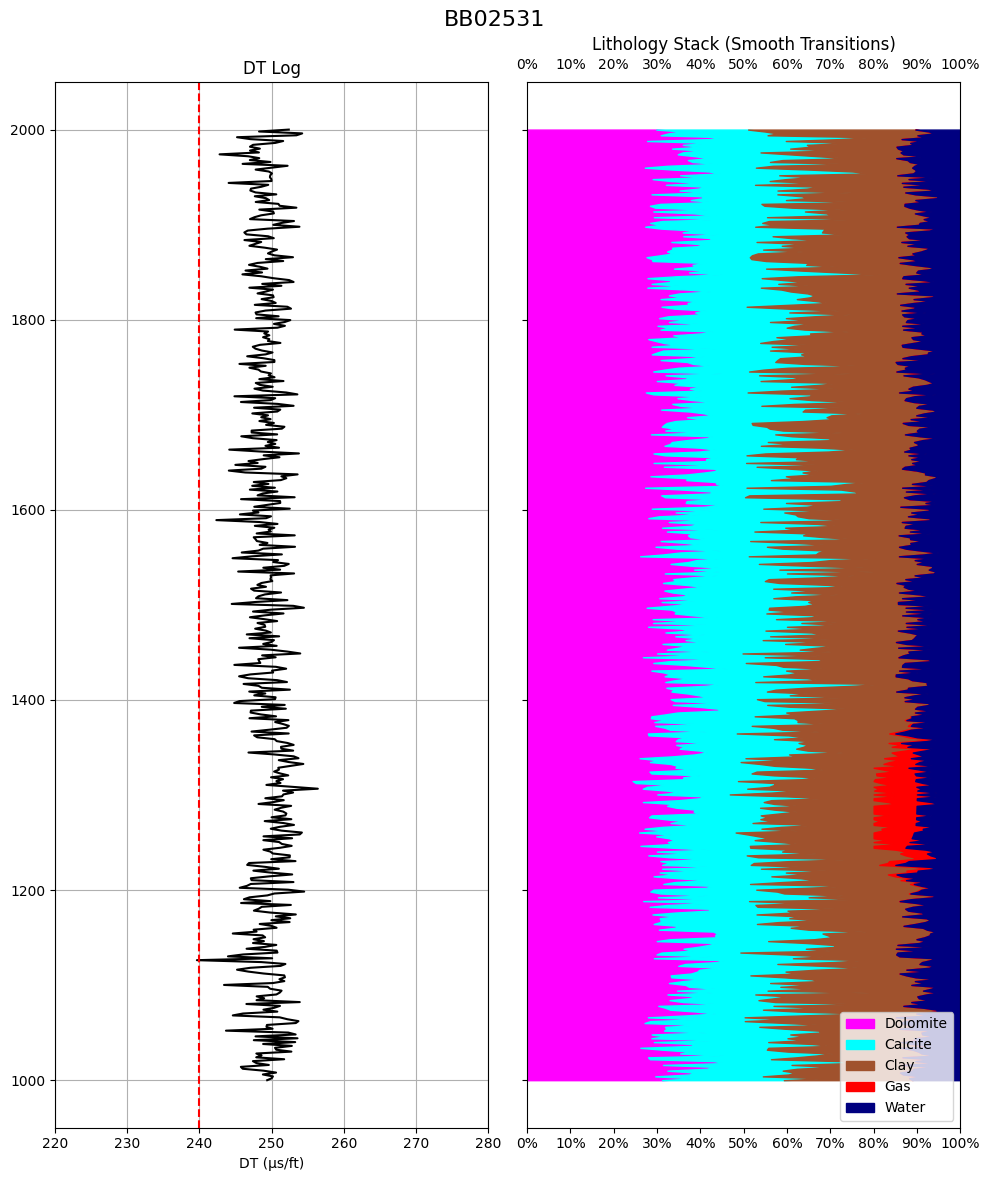

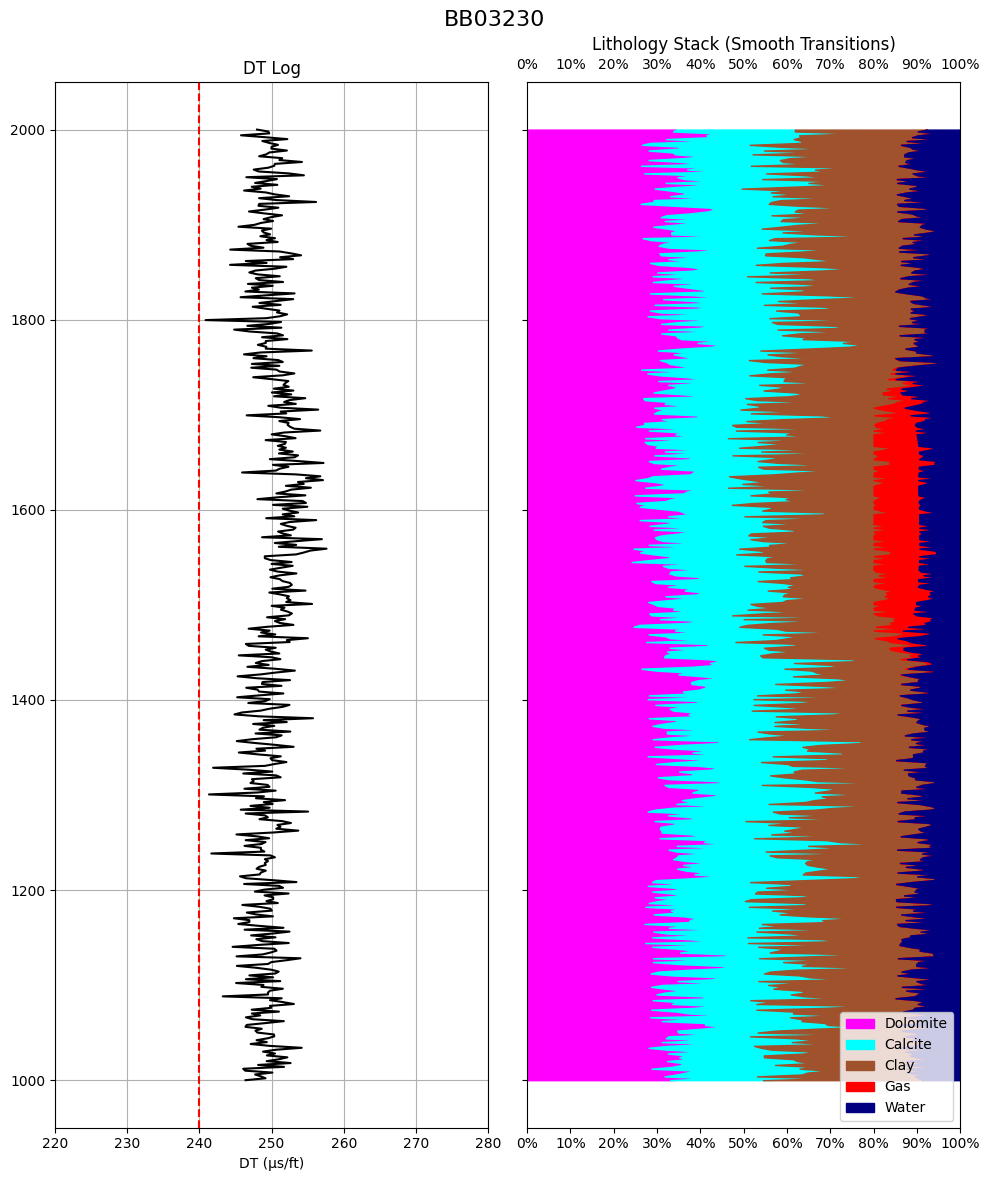

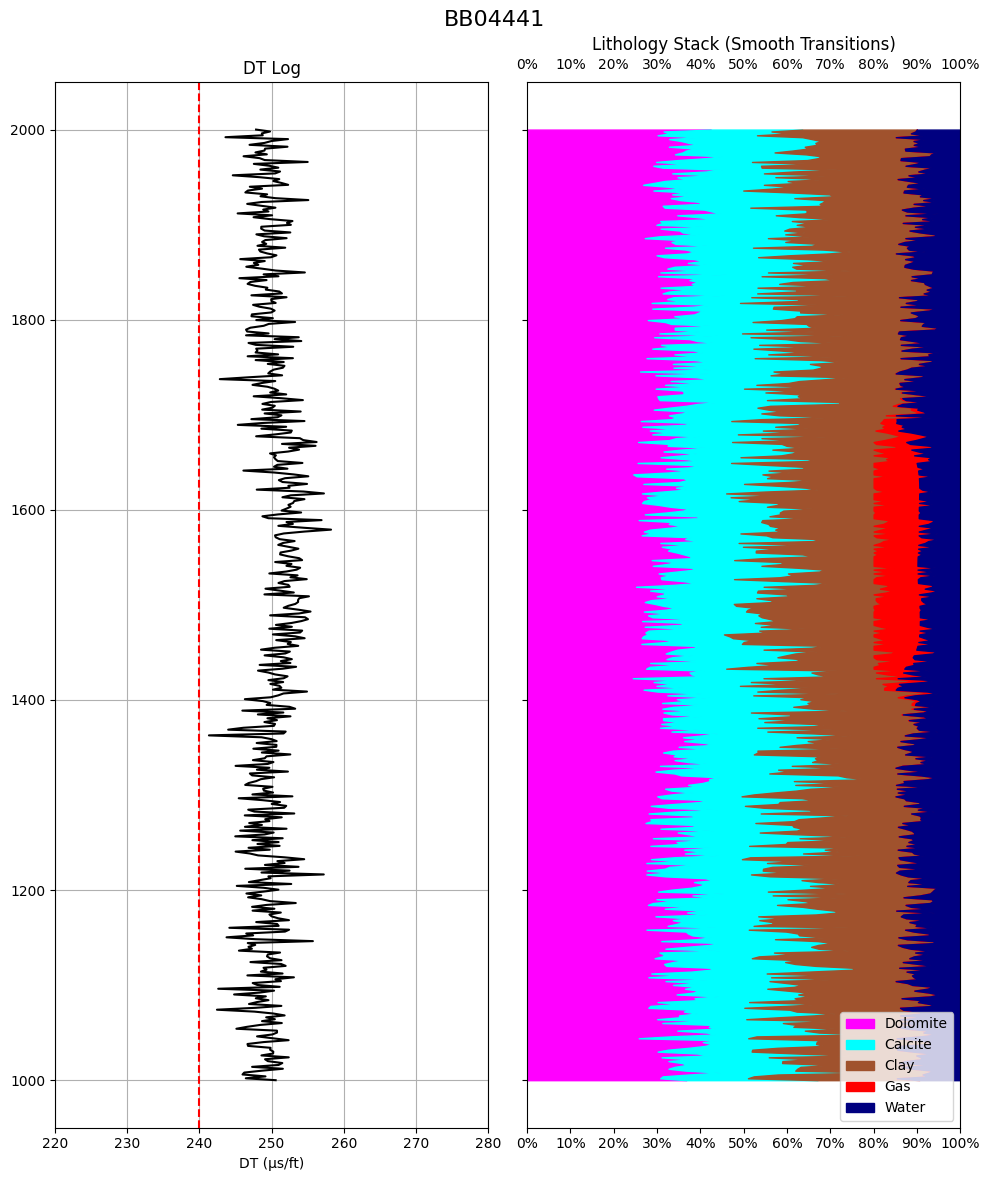

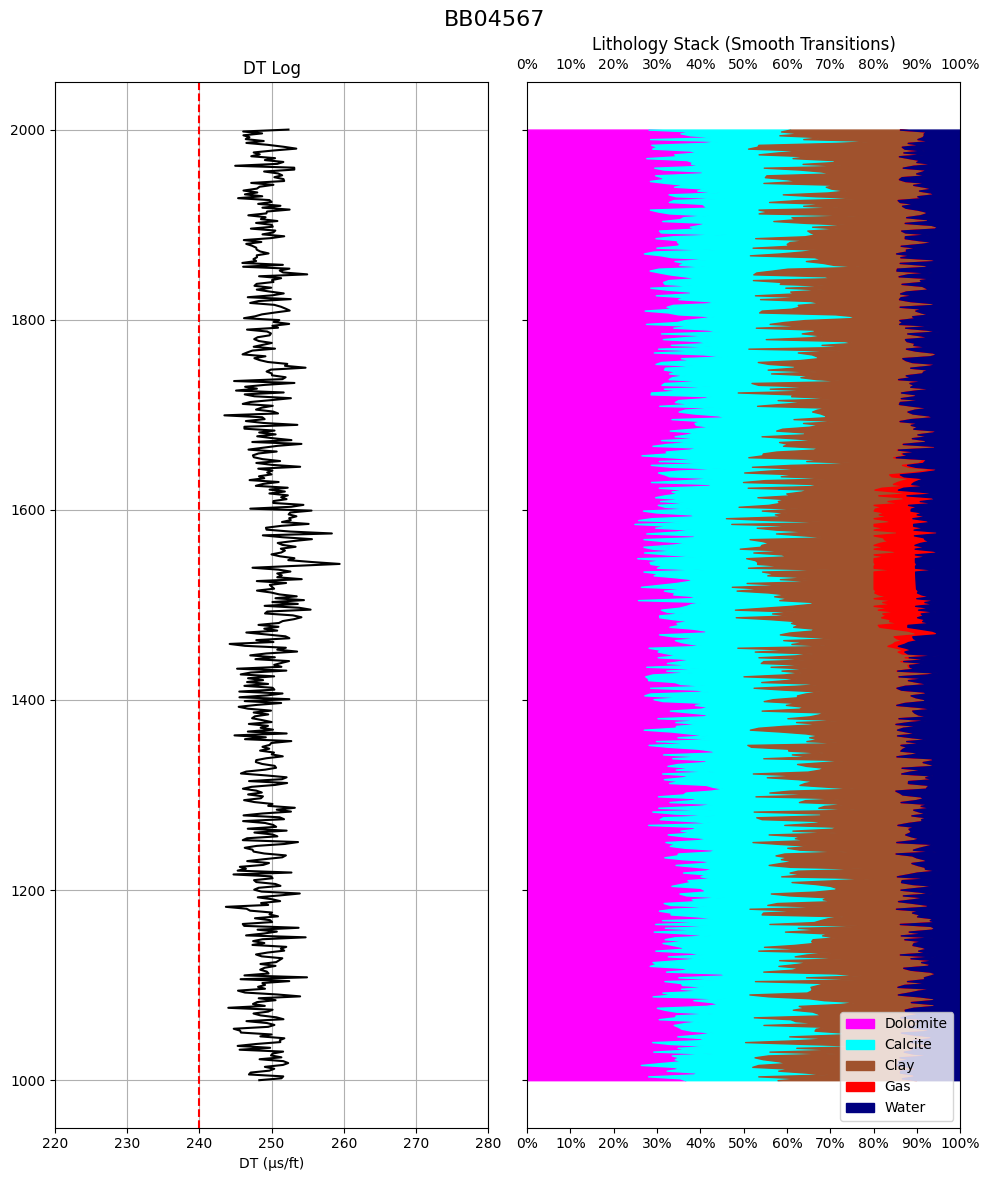

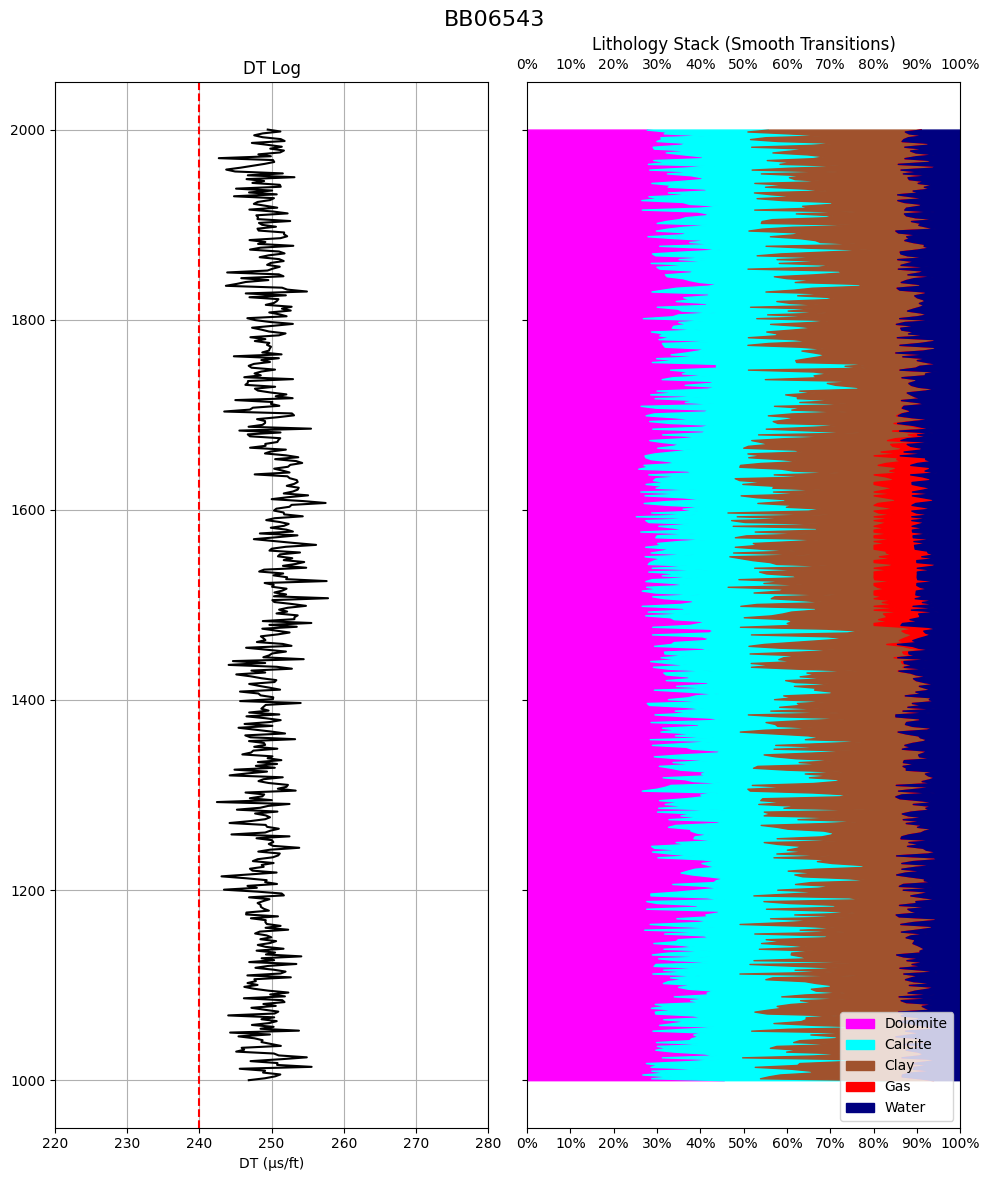

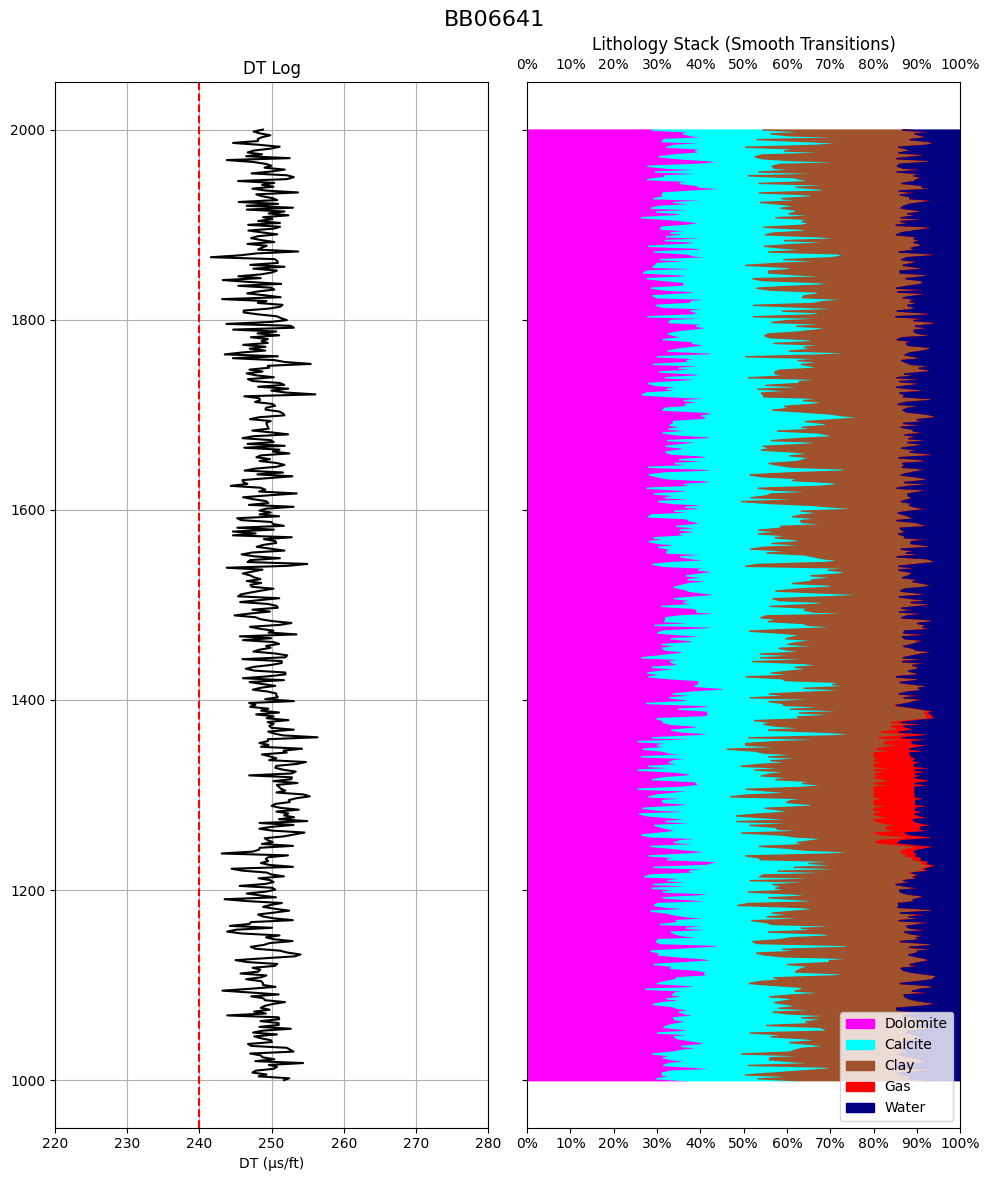

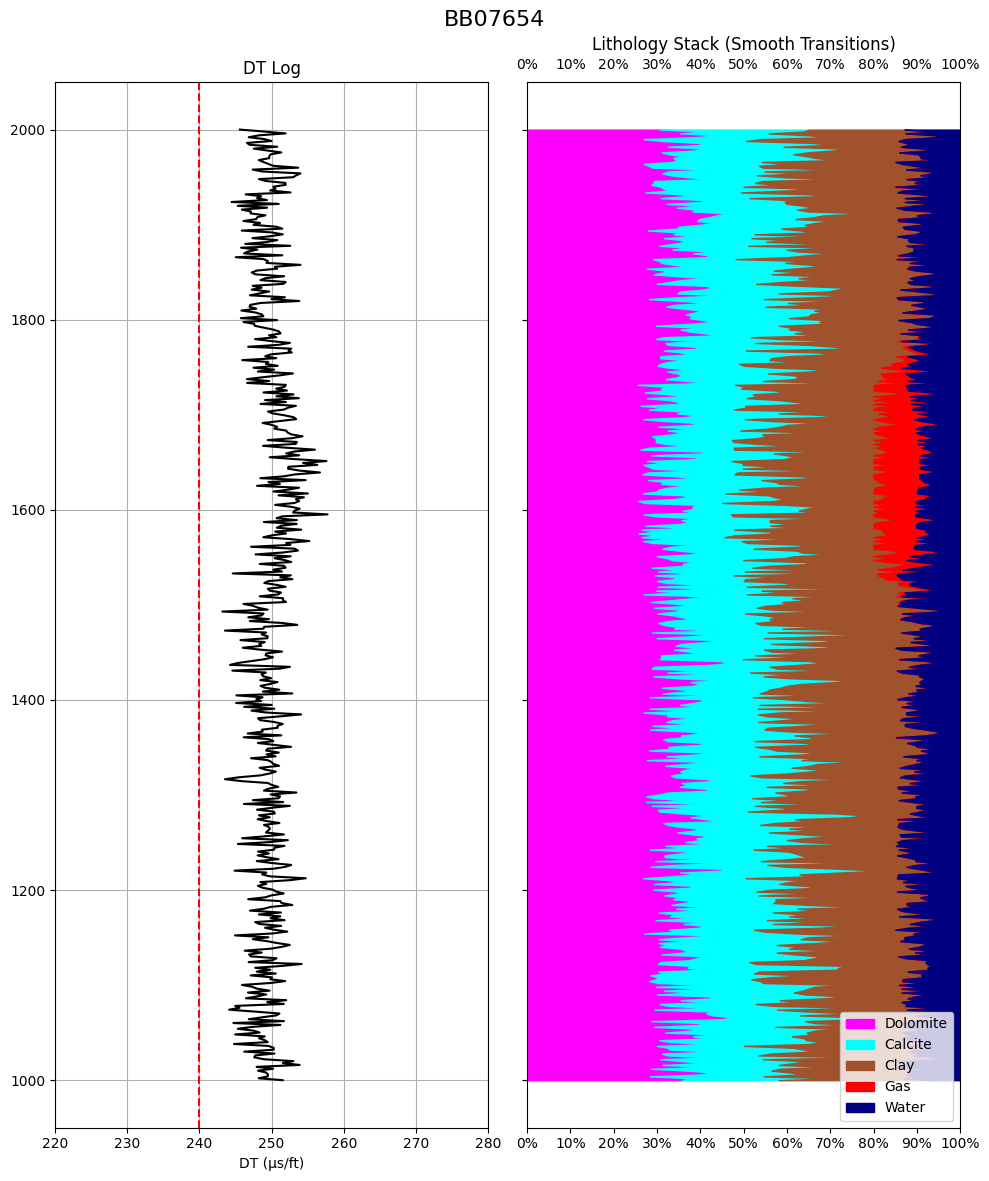

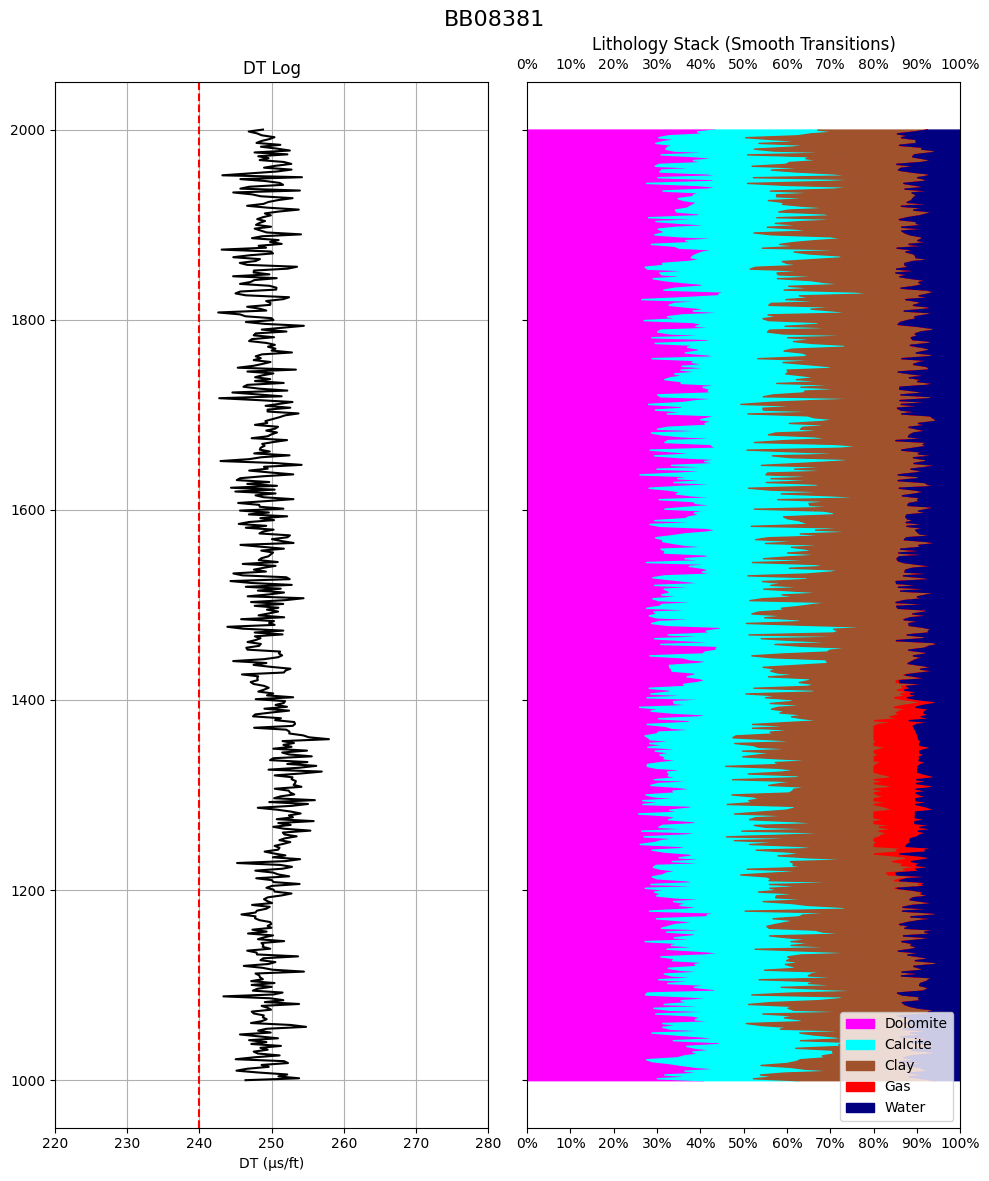

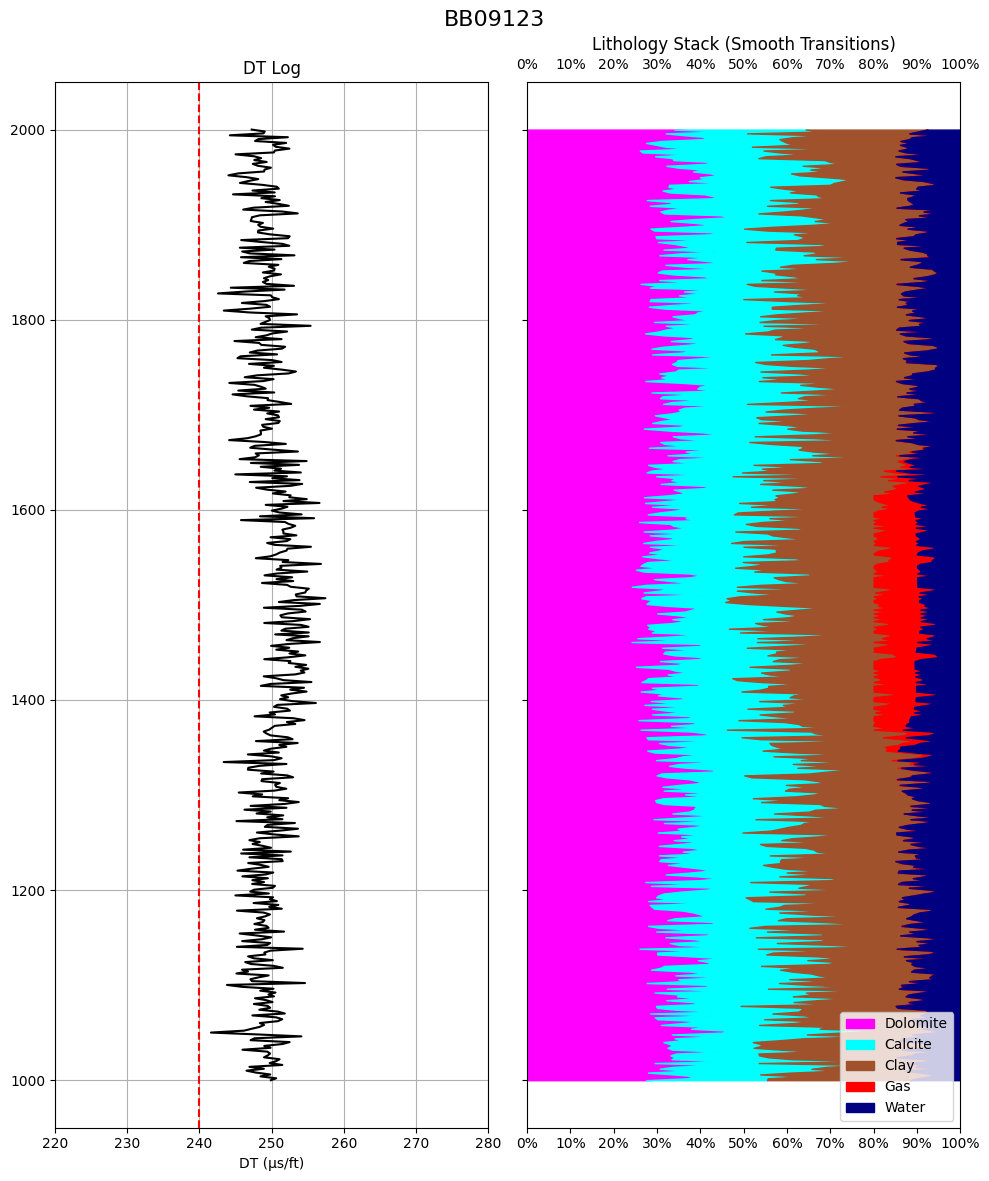

In [ ]:
las_files = sorted(glob.glob("BAB_litho_clay_smooth_logs/*.las"))

for file in las_files:
    las = lasio.read(file)
    well = las.well.WELL.value
    depth = las["DEPT"]
    dt = las["DT"]
    dolomite = las["DOLOMITE"] / 100
    calcite = las["CALCITE"] / 100
    clay = las["CLAY"] / 100
    gas = las["GAS"] / 100
    water = las["WATER"] / 100

    fig, axs = plt.subplots(1, 2, figsize=(10, 12), sharey=True)
    fig.suptitle(well, fontsize=16)

    axs[0].plot(dt, depth, color='black')
    axs[0].axvline(x=240, color='red', linestyle='--')
    axs[0].set_xlim(220, 280)
    axs[0].invert_yaxis()
    axs[0].set_xlabel("DT (µs/ft)")
    axs[0].set_title("DT Log")
    axs[0].grid(True)

    bottom = np.zeros_like(depth)
    axs[1].fill_betweenx(depth, bottom, bottom + dolomite, color="#FF00FF", label="Dolomite")
    bottom += dolomite
    axs[1].fill_betweenx(depth, bottom, bottom + calcite, color="#00FFFF", label="Calcite")
    bottom += calcite
    axs[1].fill_betweenx(depth, bottom, bottom + clay, color="#A0522D", label="Clay")
    bottom += clay
    axs[1].fill_betweenx(depth, bottom, bottom + gas, color="red", label="Gas")
    bottom += gas
    axs[1].fill_betweenx(depth, bottom, 1, color="navy", label="Water")

    axs[1].set_xlim(0, 1)
    axs[1].set_xticks(np.linspace(0, 1, 11))
    axs[1].set_xticklabels([f"{int(x*100)}%" for x in np.linspace(0, 1, 11)])
    axs[1].tick_params(axis='x', labeltop=True, labelbottom=True)
    axs[1].xaxis.set_label_position('top')
    axs[1].invert_yaxis()
    axs[1].set_title("Lithology Stack (Smooth Transitions)")
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
